# 『ゼロから始めるDeepLeaning』7章：畳み込みニューラルネットワーク(CNN)

今回用いるファイルは

mnist.py,simple_convnet.py,trainer.py,collections.py,im2col.py,layers.py,optimizer.py

になります．

## 講義の流れ

### 0.深層にするには？

### 1.畳み込み演算の理解

### 2.プーリング層の理解

### 3.畳み込み層とプーリング層の実装

### 4.代表的なCNNの紹介とアーキテクチャの見方


In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.pardir) # 親ディレクトリのファイルをインポートするための設定
from collections import OrderedDict # Pythonの順序付き辞書型を扱うためのライブラリ

plt.style.use('ggplot')

# ここから下は、ゼロから作るDeepLearningのライブラリをインポートしている
# from mnist import load_mnist # mnistデータセットを読み込むためのライブラリ
# from simple_convnet import SimpleConvNet # 畳み込み実装の実装のためのライブラリ
# from trainer import Trainer # 学習を行うためのライブラリ
# from im2col import * # im2colのためのライブラリ
# from layers import * # 各レイヤーを扱うためのライブラリ
# from optimizer import * # 最適化手法を扱うためのライブラリ

## 0.深層にするには？

/home/taichi/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/home/taichi/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/taichi/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/taichi/anaconda3/lib/python3.10/site-packages

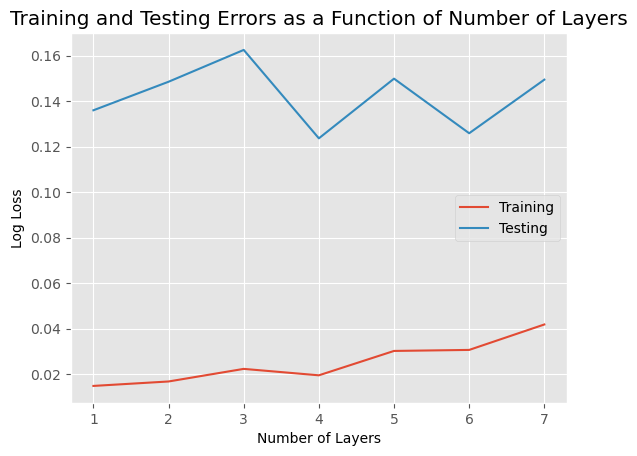

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Normalize inputs from 0-255 to 0-1
X = X / 255.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List to store training and testing errors
training_errors = []
testing_errors = []

# Number of layers to test

#layers = [(50,), (50, 50), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50)] # 1~5層

layers = [(50,), (50, 50), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50),
          (50, 50, 50, 50, 50, 50), (50, 50, 50, 50, 50, 50, 50)] # 1 ~ 7層




for layer in layers:
    mlp = MLPClassifier(hidden_layer_sizes=layer, max_iter=20, alpha=1e-4,
                        solver='sgd', verbose=0, random_state=1,
                        learning_rate_init=.1)
    mlp.fit(X_train, y_train)
    training_errors.append(log_loss(y_train, mlp.predict_proba(X_train)))
    testing_errors.append(log_loss(y_test, mlp.predict_proba(X_test)))

# Plot training and testing errors
plt.plot([len(layer) for layer in layers], training_errors, label='Training')
plt.plot([len(layer) for layer in layers], testing_errors, label='Testing')

plt.title('Training and Testing Errors as a Function of Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


In [10]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 20.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.5 MB/s eta 0:00:000:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 777.3 kB/s eta 0:00:000:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.1 MB/s eta 0:00:0031m19.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 M

In [12]:
import tensorflow as tf

In [13]:
# ここから下は、kerasをインポートしている
import keras

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

2023-05-20 14:52:50.932300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-20 14:52:50.967225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-20 14:52:50.967826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 14:52:51.590655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


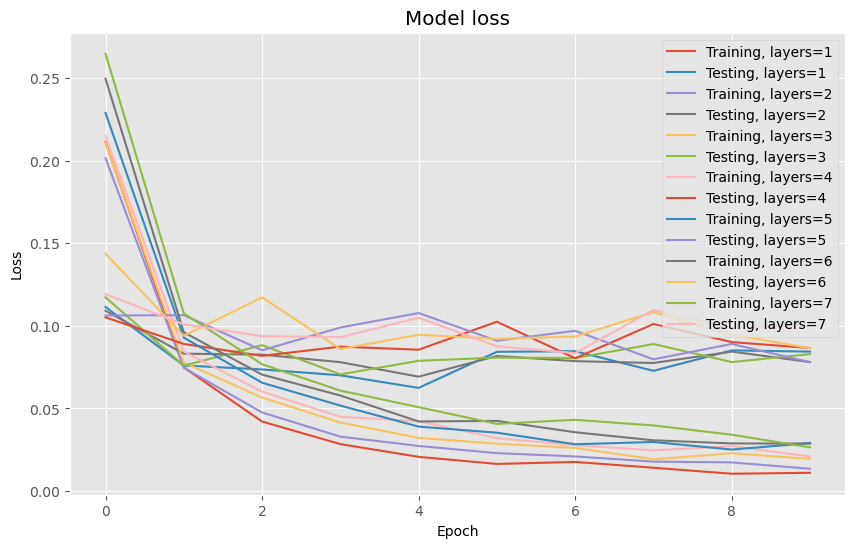

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

# Normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# One hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

def create_model(num_layers):
    # Create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    for _ in range(num_layers):
        model.add(Dense(num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# List to store training and testing errors
training_errors = []
testing_errors = []

# Number of layers to test
layers = [1, 2, 3, 4, 5, 6, 7]

for num_layers in layers:
    model = create_model(num_layers)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=0)
    training_errors.append(history.history['loss'])
    testing_errors.append(history.history['val_loss'])

# Plot training and testing errors
plt.figure(figsize=(10, 6))  # Adjust the size of the plot
for i in range(len(layers)):
    plt.plot(training_errors[i], label='Training, layers='+str(layers[i]))
    plt.plot(testing_errors[i], label='Testing, layers='+str(layers[i]))

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [17]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

# Normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# One hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]


Epoch 1/10
300/300 - 4s - loss: 0.2167 - accuracy: 0.9359 - val_loss: 0.0906 - val_accuracy: 0.9704 - 4s/epoch - 14ms/step
Epoch 2/10
300/300 - 3s - loss: 0.0742 - accuracy: 0.9777 - val_loss: 0.0768 - val_accuracy: 0.9739 - 3s/epoch - 12ms/step
Epoch 3/10
300/300 - 4s - loss: 0.0473 - accuracy: 0.9847 - val_loss: 0.0712 - val_accuracy: 0.9780 - 4s/epoch - 12ms/step
Epoch 4/10
300/300 - 4s - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.0676 - val_accuracy: 0.9805 - 4s/epoch - 12ms/step
Epoch 5/10
300/300 - 3s - loss: 0.0222 - accuracy: 0.9929 - val_loss: 0.0826 - val_accuracy: 0.9757 - 3s/epoch - 11ms/step
Epoch 6/10
300/300 - 3s - loss: 0.0183 - accuracy: 0.9938 - val_loss: 0.0804 - val_accuracy: 0.9772 - 3s/epoch - 11ms/step
Epoch 7/10
300/300 - 3s - loss: 0.0162 - accuracy: 0.9945 - val_loss: 0.0787 - val_accuracy: 0.9808 - 3s/epoch - 12ms/step
Epoch 8/10
300/300 - 3s - loss: 0.0139 - accuracy: 0.9951 - val_loss: 0.0811 - val_accuracy: 0.9804 - 3s/epoch - 11ms/step
Epoch 9/10
300/3

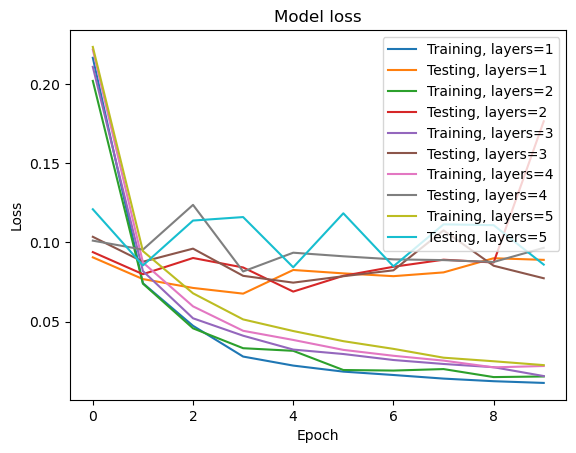

In [18]:
def create_model(num_layers):
    # Create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    for _ in range(num_layers):
        model.add(Dense(num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# List to store training and testing errors
training_errors = []
testing_errors = []

# Number of layers to test
layers = [1, 2, 3, 4, 5]

for num_layers in layers:
    model = create_model(num_layers)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
    training_errors.append(history.history['loss'])
    testing_errors.append(history.history['val_loss'])

# Plot training and testing errors
for i in range(len(layers)):
    plt.plot(training_errors[i], label='Training, layers='+str(layers[i]))
    plt.plot(testing_errors[i], label='Testing, layers='+str(layers[i]))

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## 概要
題目にある畳み込みニューラルネットワーク(CNN)は，これまで学習してきた全結合層(Affine)のニューラルネットワークを工夫したものになっています．

もともと全結合層には以下の欠点がありました．

#### 1.層を増やしたり入力次元を増やしたりすると，それに伴ってパラメータが爆発的に増えてしまう．

#### 2.入力データの次元を変えられない．

これらを解消するために開発されたのが畳み込み演算を用いたニューラルネットワークになります．

ここから，CNNの概要を簡単に説明します．

### 畳み込みニューラルネットワークにおける2つの構成要素

CNNでは全結合層に加えて，新たに『畳み込み層』と『プーリング層』が登場します．

~~まずは，白板でこれら実装を行うための演算を学びましょう．~~



### 出力サイズの確認
$$
O = \lfloor \frac{I + 2P - K}{S} \rfloor+1\\
$$
$O:出力サイズ，I:入力サイズ，P:パディングサイズ，K:フィルターサイズ$

## im2col(image to column)
参考：https://qiita.com/kuroitu/items/35d7b5a4bde470f69570

https://www.youtube.com/watch?v=9s83xaQzAuA

ここからは画像データを行列に変換する関数『im2col』を学びます．

畳み込みの実装は，真面目にやるとfor文を繰り返し使用することになります．

これは面倒であると同時に，Numpyとfor文との相性が悪い（計算に時間がかかる）ため処理が遅くなる欠点があります．

そこでim2colという便利な関数を用いたシンプルな実装を行います．

まずは理解のために簡単な例で実装をしましょう．
$$
\begin{bmatrix}
1 & 1 & 1 & 1 \\
2 & 2 & 2 & 2 \\
3 & 3 & 3 & 3 \\
4 & 4 & 4 & 4 \\
\end{bmatrix}
\ast
\begin{bmatrix}
1 & 0 \\
1 & 0 \\
\end{bmatrix}
=
\begin{bmatrix}
a & b & c \\
d & e & f \\
g & h & i \\
\end{bmatrix}
$$
という畳み込み計算を実装します．

これは内積の形で以下のように書けます
$$
\begin{bmatrix}
1 & 0 & 1 & 0 \\
\end{bmatrix}
・
\begin{bmatrix}
1 & 1 & 1 & 2 &・・・&3\\
1 & 1 & 1 & 2 &・・・&3\\
2 & 2 & 2 & 3 &・・・&4\\
2 & 2 & 2 & 3 &・・・&4\\
\end{bmatrix}
=
\begin{bmatrix}
a & b & c & d & e & f & g & h & i \\
\end{bmatrix}
$$

この計算における左辺の左側
$$
\begin{bmatrix}
1 & 1 & 1 & 2 &・・・&3\\
1 & 1 & 1 & 2 &・・・&3\\
2 & 2 & 2 & 3 &・・・&4\\
2 & 2 & 2 & 3 &・・・&4\\
\end{bmatrix}
$$
をim2colは作成します．

In [23]:
import numpy as np

In [24]:
# 入力データ
x = np.array([[1,1,1,1],
              [2,2,2,2],
              [3,3,3,3],
              [4,4,4,4]])
x

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4]])

In [25]:
len(x)

4

In [26]:
# カーネル
k = np.array([[1,0],
              [1,0]])
k

array([[1, 0],
       [1, 0]])

In [27]:
# アウトプットサイズの計算を行う関数
def output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1

In [28]:
o = output_size(len(x) , len(k) , stride=1, pad=0)
o = int(o)

In [29]:
x_col = np.zeros((len(k)*len(k) , o*o))
x_col

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [30]:
# 試しに、xの左上の2x2の部分を取り出して、x_colの一番左に入れてみる
x_col[: , 0] = x[0:2 , 0:2].reshape(-1)
# その次に、xの左から2番目の2x2の部分を取り出して、x_colの2列目に入れてみる
x_col[: , 1] = x[0:2 , 1:3].reshape(-1) # .reshape(-1)は、1次元配列に変換するメソッド．列方向に並べる
x_col

array([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
# 実際にim2colを行う関数を作成する
def im2col(x , fil_size , output_size):
    x_col = np.zeros((fil_size*fil_size , output_size*output_size))
    for i in range(output_size):
        for j in range(output_size):
            x_col[: , i*output_size+j] = x[i:i+fil_size , j:j+fil_size].reshape(-1)
    return x_col

In [32]:
im2col(x , len(k) , o)

array([[1., 1., 1., 2., 2., 2., 3., 3., 3.],
       [1., 1., 1., 2., 2., 2., 3., 3., 3.],
       [2., 2., 2., 3., 3., 3., 4., 4., 4.],
       [2., 2., 2., 3., 3., 3., 4., 4., 4.]])

以上の様にim2colとは，フィルターにとって都合の良いように入力データを展開する関数になります．

教科書ではブラックボックスで使用することを想定していますが，教科書で想定されているim2col関数を以下に示しておきます．また，im2col.pyに同様のコードがありますので必要に応じて参照してください．



In [33]:
# 画像から行列への変換．
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

実際に実行をしてみましょう．

入力には(バッチサイズ , チャンネル数 , 縦 , 横)という情報を含み，

im2colの引数は(入力データ，フィルターサイズ縦 , フィルターサイズ横 , ストライド幅 , パディングサイズ)という具合になっています．

以下では2つの例を示しています．

In [34]:
x1 = np.random.rand(1, 3, 7, 7) # 入力データ
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 10個のデータ
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


出力は
$$
（アウトプットサイズの積　，チャンネル数×フィルターサイズの積）
$$
になるはずです．

以上が畳み込み計算を効率良く行うための基本的な関数であるim2colの説明でした．

## 畳み込み層(Convolution layer)の実装

ここからは畳み込み層の実装に入ります．

引数として，カーネルの情報を必要とします．具体的には，各要素の値，ストライド幅，パディングサイズです．

その後，先程作成したim2col関数を用いて畳み込み演算を行い，バイアス項を付けて出力値を得ます．

In [35]:
class Convolution:
    def __init__(self , W , b , stride=1 , pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self , x):
        FN , C , FH , FW = self.W.shape
        N , C , H , W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH)/self.stride)
        out_w = int(1 + (W + 2*self.pad - FW)/self.stride)

        col = im2col(x , FH , FW , self.stride , self.pad)
        col_W = self.W.reshape(FN , -1).T
        out = np.dot(col , col_W) + self.b

        out = out.reshape(N , out_h , out_w , -1).transpose(0 , 3 , 1 , 2)
        
        return out

.transposeメソットは初めて出てきましたので説明します．

https://deepage.net/features/numpy-transpose.html

出力値は(バッチサイズ，高さ，幅，チャンネル数)となっているため，（バッチサイズ，チャンネル，高さ，幅）と変更したいです．そのためのインデックスの順番変更のためにこのメソッドを使いました．

この様にim2colを用いてあげれば，内積の形で畳み込みができたことを思い出すと理解できるように，全結合層と同じ様に実装が可能です．

続いて逆伝播ですが全結合層と異なるのは，2次元配列に戻す手間があることです．以下に2次元配列に変換するためのcol2im関数を表示させます．先ほどと同様にim2col.pyにも同じ関数が存在します．

In [36]:
# 行列から画像への変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

このcol2im関数を用いて順伝搬及び逆伝搬が揃ったクラスを以下に示します．これはlayer.pyファイルに存在します．

In [37]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None
 
 # 順伝播
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out
# 逆伝播
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

## プーリング層(Pooling layer)の実装

続いてプーリング層の実装に移ります．

教科書ではいわゆるMaxPoolingの説明をしています．

カーネルサイズの範囲で最大値を返すこと以外は，畳み込み層の実装と大差はありませんので実際のclassを以下に示しておきます．

In [38]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## CNNの実装
Convolution層とPooling層を実装したので，いよいよ畳み込みニューラルネットワークの実装に移ります．

### アーキテクチャ(SimpleConvNet)
Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax

### 引数
input_dim : 入力データの次元(チャンネル，高さ，幅)

conv_param : 畳み込み層のハイパーパラメータ

hidden_size : 隠れ層

output_size : 出力層

weight_init_std : 初期化時の標準偏差

In [39]:
from utils.layers import *
from utils.functions import *

class SimpleConvNet:
    # SimpleConvNetの初期化処理
    def __init__(self , input_dim=(1 , 28 , 28) , conv_param={'filter_num':30 , 'filter_size':5 , 'pad':0 , 'stride':1} , hidden_size=100 , output_size=10 , weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad)/filter_stride + 1
        pool_output_size = int(filter_num*(conv_output_size/2)*(conv_output_size/2))

        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(filter_num , input_dim[0] , filter_size , filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std*np.random.randn(pool_output_size , hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std*np.random.randn(hidden_size , output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'] , self.params['b1'] , conv_param['stride'] , conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2 , pool_w=2 , stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'] , self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'] , self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    # 推論処理
    def predict(self , x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    # 損失関数の計算
    def loss(self , x , t):
        y = self.predict(x)
        return self.last_layer.forward(y , t)
    
    # 認識精度の計算
    def gradient(self , x , t):
        # forward
        self.loss(x , t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

### MNISTデータセットを用いて学習をしてみましょう

=== epoch:1, train acc:0.119, test acc:0.115 ===
=== epoch:2, train acc:0.958, test acc:0.963 ===
=== epoch:3, train acc:0.977, test acc:0.979 ===
=== epoch:4, train acc:0.986, test acc:0.979 ===
=== epoch:5, train acc:0.99, test acc:0.982 ===
=== epoch:6, train acc:0.986, test acc:0.986 ===
=== epoch:7, train acc:0.99, test acc:0.979 ===
=== epoch:8, train acc:0.986, test acc:0.98 ===
=== epoch:9, train acc:0.996, test acc:0.988 ===
=== epoch:10, train acc:0.995, test acc:0.984 ===
=== epoch:11, train acc:0.993, test acc:0.988 ===
=== epoch:12, train acc:0.996, test acc:0.985 ===
=== epoch:13, train acc:0.999, test acc:0.991 ===
=== epoch:14, train acc:0.996, test acc:0.983 ===
=== epoch:15, train acc:0.998, test acc:0.986 ===
=== epoch:16, train acc:0.998, test acc:0.983 ===
=== epoch:17, train acc:0.998, test acc:0.982 ===
=== epoch:18, train acc:0.996, test acc:0.986 ===
=== epoch:19, train acc:0.994, test acc:0.985 ===
=== epoch:20, train acc:0.999, test acc:0.985 ===
============

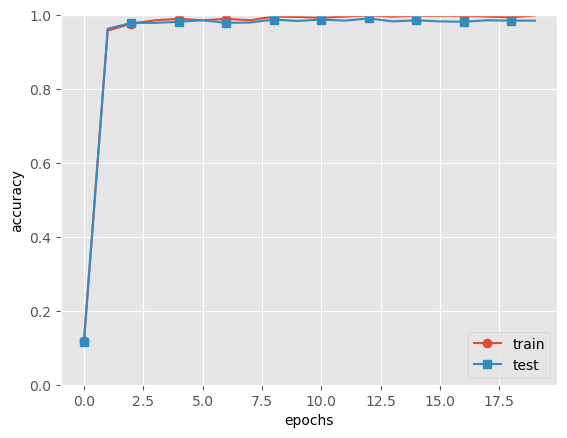

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from utils.mnist import load_mnist
from simple_convnet import SimpleConvNet
from utils.trainer import Trainer


plt.style.use('ggplot')

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

結果として訓練識別率99.99%，テスト識別率98.97%となるようです．

かなり早い段階で学習がうまく行っているようなのでバッチサイズは減らせそうですね．

## CNNの可視化
畳み込み層は”何を見ている"のでしょうか？

畳み込みとは，そもそも相関を表す指標です．今回の場合では，入力とカーネルとの似ている具合を抽出していることになります．

以下では，先程の学習に関する畳み込みのフィルターを画像として表示してみましょう．

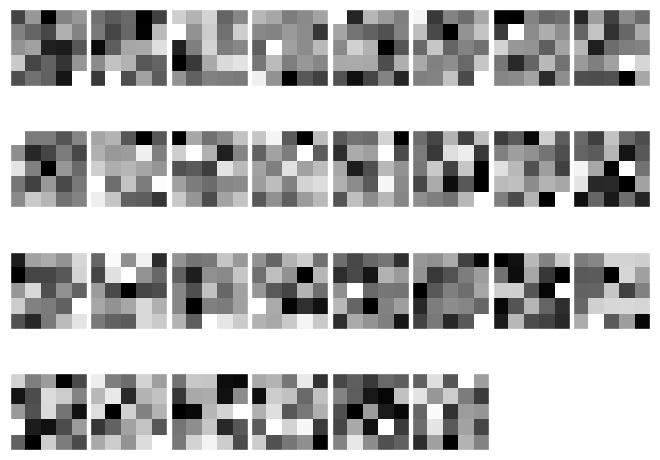

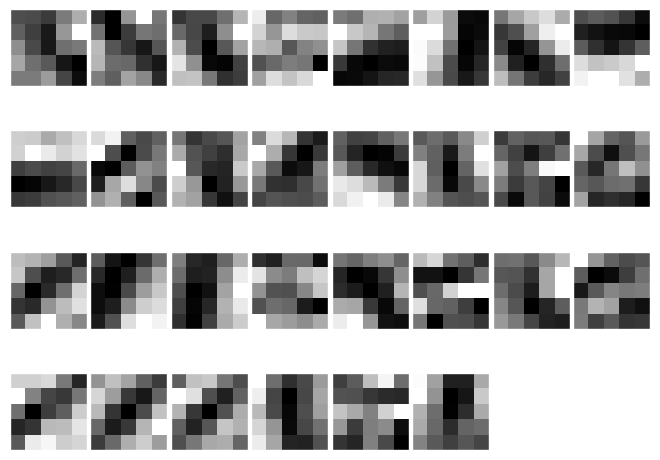

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

上が学習前で，下が学習後です．

学習後は学習前に比べてある程度の規則性が現れているのが見て取れます．

このようなフィルターが見ているものとは「エッジ」や「ブロブ」と呼ばれるものです．

エッジとは，色が変化する境目であり，ブロブとは，局所的に塊がある領域です．

たとえば，左が白で右が黒である場合には，縦方向のエッジに反応するフィルターになります．（教科書図7-25）

## 代表的なCNN
この資料の最後にこれまでの歴史上で有名なCNNについて紹介します．

### LeNet
LeNet5の原著論文：
http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

わかりやすい動画：
https://www.youtube.com/watch?v=-tWolA2WvFI

畳み込み，平均プーリング．畳み込み，平均プーリング，全結合，全結合という流れのニューラルネットワークです．

### AlexNet
原著論文：
https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

わかりやすい動画：
https://www.youtube.com/watch?v=KebUnMbOGU8

第3次AIブームの火付け役

畳み込み層とプーリング層の繰り返しが8回，全結合3回という流れのニューラルネット